In [16]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers, callbacks
from sklearn.datasets import fetch_openml 
from sklearn.model_selection import train_test_split

In [2]:
data = fetch_openml('Kuzushiji-MNIST')

In [3]:
X, t = data.data.to_numpy(), data.target.to_numpy()
X = X/255. # accomplishes the scaling
X = X.reshape((70000,28,28))
t = t.astype(np.uint8)

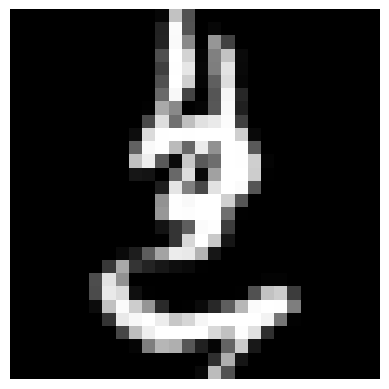

In [ ]:
plt.imshow(X[34566], cmap='gray')
plt.axis('off')

In [5]:
X_train, X_test, t_train, t_test = X[:60000], X[60000:], t[:60000], t[60000:]
X_train, X_val, t_train, t_val = train_test_split(X_train, t_train, 
                                                  test_size = 0.20,
                                                  stratify = t_train)

In [24]:
# Hyperparameters to tune: learning rate, beta values, bottleneck size, 
lr = 0.005
B1 = 0.9
B2 = 0.999
bottleneck = 50

In [25]:
# custom SAE loss
# class SAEloss(tf.keras.losses.Loss):
#     def __init__(self, name="SAE_loss"):
#         # You can initialize any additional parameters for your loss here
#         super().__init__(name=name)

#     def call(self, y_true, y_pred):
#         """
#         This method defines the loss computation. The output of this function will
#         be used to calculate the loss during training.

#         Args:
#             y_true: Tensor of true labels.
#             y_pred: Tensor of predicted values.

#         Returns:
#             A scalar Tensor representing the loss value.
#         """
#         # Example of Mean Squared Error (MSE) loss
#         loss_value = tf.reduce_mean(tf.square(y_true - y_pred))

#         # Optionally, you can add more loss methods based on specific conditions
#         # Example: Adding a regularization term
#         # regularization_loss = some_regularization_term(y_pred)

#         # If you have multiple components in your loss, you can return their sum
#         # return loss_value + regularization_loss
        
#         return loss_value
    

In [29]:
encoder = models.Sequential([
    layers.Flatten(input_shape=[28,28]),
    layers.Dense(800,  activation='relu', use_bias=False),
    layers.Dense(200,  activation='relu', use_bias=False),
    layers.Dense(bottleneck,  activation='relu', use_bias=False)
])

decoder = models.Sequential([
    layers.Dense(200,  activation='relu', use_bias=False),
    layers.Dense(800,  activation='relu', use_bias=False),
    layers.Dense(28*28, use_bias=False),
    layers.Reshape([28, 28])
])

autoencoder = models.Sequential([encoder, decoder])

autoencoder.compile(loss=losses.MeanSquaredError(reduction="sum_over_batch_size"), 
                    optimizer=optimizers.Adam(learning_rate=lr,
                    beta_1=B1,
                    beta_2=B2))

In [30]:
callback1=callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = autoencoder.fit(X_train, X_train, epochs=30, 
                    validation_data=(X_val, X_val),
                    callbacks=callback1)

Epoch 1/30
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0675 - val_loss: 0.0570
Epoch 2/30
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0549 - val_loss: 0.0543
Epoch 3/30
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0525 - val_loss: 0.0517
Epoch 4/30
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0513 - val_loss: 0.0505
Epoch 5/30
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0508 - val_loss: 0.0508
Epoch 6/30
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0503 - val_loss: 0.0510
Epoch 7/30
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0501 - val_loss: 0.0512
Epoch 8/30
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0497 - val_loss: 0.0510
Epoch 9/30
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0495 - val_loss: 0.0513
Epoch 10/30
1500/1500 [==============================] - 2s 1ms/step - loss: 0.049

In [ ]:
# Evaluation
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# PCA as information for the bottleneck tuning
While SAE offers increased functionality to PCA by creating weights that can be used in other functions such as VAE generation, at its core the SAE training serves the same function as PCA: dimensionality reduction. To this end, to inform our bottleneck tuning we can use PCA on the data and figure out how many dimensions we can remove while keeping 95% of the variation

In [39]:
# Perform PCA to find out how much dimensionality reduction we can do
from sklearn.decomposition import PCA
expVar1 = 0.95
expVar2 = 0.99
expVar3 = 0.999


avg_dims1 = 0
avg_dims2 = 0
avg_dims3 = 0



for iii in range(X_train.shape[0]):
    
    my_pca1 = PCA(n_components = expVar1)
    my_pca2 = PCA(n_components = expVar2)
    my_pca3 = PCA(n_components = expVar3)

    my_pca1.fit(X_train[iii,:,:])
    my_pca2.fit(X_train[iii,:,:])
    my_pca3.fit(X_train[iii,:,:])
    
    avg_dims1 = avg_dims1 + len(my_pca1.explained_variance_ratio_)
    avg_dims2 = avg_dims2 + len(my_pca2.explained_variance_ratio_)
    avg_dims3 = avg_dims3 + len(my_pca3.explained_variance_ratio_)
    
avg_dims1 = avg_dims1 / X_train.shape[0]
avg_dims2 = avg_dims2 / X_train.shape[0]
avg_dims3 = avg_dims3 / X_train.shape[0]

In [40]:
print(avg_dims1)
print(avg_dims2)
print(avg_dims3)

7.1459375
11.061916666666667
15.506791666666667


In [48]:
# Train 3 autoencoders with these bottleneck layers and see the results
lr = 0.001
B1 = 0.9
B2 = 0.999
bottleneck1 = 8
bottleneck2 = 12
bottleneck3 = 16

encoder1 = models.Sequential([
    layers.Flatten(input_shape=[28,28]),
    layers.Dense(800,  activation='relu', use_bias=False),
    layers.Dense(200,  activation='relu', use_bias=False),
    layers.Dense(bottleneck1,  activation='relu', use_bias=False)
])

encoder2 = models.Sequential([
    layers.Flatten(input_shape=[28,28]),
    layers.Dense(800,  activation='relu', use_bias=False),
    layers.Dense(200,  activation='relu', use_bias=False),
    layers.Dense(bottleneck2,  activation='relu', use_bias=False)
])

encoder3 = models.Sequential([
    layers.Flatten(input_shape=[28,28]),
    layers.Dense(800,  activation='relu', use_bias=False),
    layers.Dense(200,  activation='relu', use_bias=False),
    layers.Dense(bottleneck3,  activation='relu', use_bias=False)
])

decoder1 = models.Sequential([
    layers.Dense(200,  activation='relu', use_bias=False),
    layers.Dense(800,  activation='relu', use_bias=False),
    layers.Dense(28*28, use_bias=False),
    layers.Reshape([28, 28])
])

decoder2 = models.Sequential([
    layers.Dense(200,  activation='relu', use_bias=False),
    layers.Dense(800,  activation='relu', use_bias=False),
    layers.Dense(28*28, use_bias=False),
    layers.Reshape([28, 28])
])

decoder3 = models.Sequential([
    layers.Dense(200,  activation='relu', use_bias=False),
    layers.Dense(800,  activation='relu', use_bias=False),
    layers.Dense(28*28, use_bias=False),
    layers.Reshape([28, 28])
])

autoencoder1 = models.Sequential([encoder1, decoder1])
autoencoder2 = models.Sequential([encoder2, decoder2])
autoencoder3 = models.Sequential([encoder3, decoder3])

autoencoder1.compile(loss=losses.MeanSquaredError(reduction="sum_over_batch_size"), 
                    optimizer=optimizers.Adam(learning_rate=lr,
                    beta_1=B1,
                    beta_2=B2))

autoencoder2.compile(loss=losses.MeanSquaredError(reduction="sum_over_batch_size"), 
                    optimizer=optimizers.Adam(learning_rate=lr,
                    beta_1=B1,
                    beta_2=B2))

autoencoder3.compile(loss=losses.MeanSquaredError(reduction="sum_over_batch_size"), 
                    optimizer=optimizers.Adam(learning_rate=lr,
                    beta_1=B1,
                    beta_2=B2))

In [49]:
# training
callback1=callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history1 = autoencoder1.fit(X_train, X_train, epochs=100, 
                    validation_data=(X_val, X_val),
                    callbacks=callback1)

history2 = autoencoder2.fit(X_train, X_train, epochs=100, 
                    validation_data=(X_val, X_val),
                    callbacks=callback1)

history3 = autoencoder3.fit(X_train, X_train, epochs=100, 
                    validation_data=(X_val, X_val),
                    callbacks=callback1)

Epoch 1/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0774 - val_loss: 0.0705
Epoch 2/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0670 - val_loss: 0.0649
Epoch 3/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0634 - val_loss: 0.0627
Epoch 4/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0614 - val_loss: 0.0614
Epoch 5/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0592 - val_loss: 0.0589
Epoch 6/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0573 - val_loss: 0.0574
Epoch 7/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0560 - val_loss: 0.0568
Epoch 8/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0551 - val_loss: 0.0560
Epoch 9/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0543 - val_loss: 0.0557
Epoch 10/100
1500/1500 [==============================] - 2s 1ms/step - l

In [ ]:
# Function to add noise to the input
def add_gaussian_noise(input_image, mean=0.0, stddev=0.1):
    # Add Gaussian noise with mean `mean` and standard deviation `stddev`
    noise = tf.random.normal(shape=tf.shape(input_image), mean=mean, stddev=stddev)
    noisy_image = input_image + noise
    return noisy_image

784